In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # pip3 install missingno
import seaborn as sns 
sns.set_style("whitegrid")
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1. Load Data

In [2]:
df=pd.read_csv("sothebys.csv", index_col=0)

In [3]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [4]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
# df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

In [5]:
#clean up birth_year
df.birth_year=pd.to_numeric(df.birth_year,errors='coerce').astype(float)

## 2. Add Features

In [6]:
# Add year, month and season for auction time
df["auc_date"] = pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df['auc_season'] = df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [7]:
# Add a boolean column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["is_untitled"]=np.where(df["lot_title"].str.contains(words), 1, 0)

In [8]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
df["auc_order"]= df.groupby("auction_id")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

In [9]:
# returns nth_in_auction divided by lot_number = percentage through the auction the lot when lot was shown
lot_order_df = df[['nth_in_auction', 'number_of_lots']].copy()
df['percent_in_auction'] = np.round(lot_order_df.nth_in_auction / lot_order_df.number_of_lots, 3)*100

In [10]:
# Add avg_estimate
df["estimate_avg"]=(df["estimate_low"] + df["estimate_high"])/2

## 3. Convert Currency

In [11]:
# pip install --user currencyconverter
from currency_converter import CurrencyConverter
from datetime import datetime
c = CurrencyConverter(fallback_on_wrong_date=True, fallback_on_missing_rate=True)

hammer_price = df[['hammer_price_bp', 'currency', 'start_date']].copy()
est_low = df[['estimate_low', 'currency', 'start_date']].copy()
est_high = df[['estimate_high', 'currency', 'start_date']].copy()
est_avg = df[['estimate_avg', 'currency', 'start_date']].copy()

hammer_price.start_date = hammer_price.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_low.start_date = est_low.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_high.start_date = est_high.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_avg.start_date = est_avg.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)

df['hammer_price_bp_usd'] = hammer_price.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_low_usd'] = est_low.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)    
df['estimate_high_usd'] = est_high.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)
df['estimate_avg_usd'] = est_avg.apply(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2) if not pd.isnull(x[1]) else x[0], axis=1)

In [12]:
df['hammer_price_bp_usd'].describe()

count    1.881000e+04
mean     3.117394e+05
std      1.872662e+06
min      0.000000e+00
25%      8.894665e+03
50%      3.136310e+04
75%      1.116989e+05
max      7.941250e+07
Name: hammer_price_bp_usd, dtype: float64

In [13]:
# Add converted Hammer Price Range
def price_range(x):

    if x <10000:
        return "0-$10,000"
    elif x<50000:
        return "10,001-$50,000"
    elif x <500000:
        return "50,001-$500,000"
    else: return "$500,000+"
    
df["price_range"] = df["hammer_price_bp_usd"].apply(price_range)

In [14]:
df.sample(20)

,lot_id,auction_id,lot_title,estimate_low,estimate_high,hammer_price_bp,currency,nth_in_auction,lot_number,condition,provenance,literature,external_image_url,auction_house_id,auc_title,number_of_lots,location,start_date,end_date,auc_desc,sale_id,artist_id,name,birth_year,death_year,auc_date,auc_year,auc_month,auc_season,is_untitled,auc_order,percent_in_auction,estimate_avg,hammer_price_bp_usd,estimate_low_usd,estimate_high_usd,estimate_avg_usd,price_range
8387,13665,181,SANS TITRE (UNTITLED),40000.0,60000.0,87500.0,HKD,72,79,This work is generally in good condition. A li...,"Denmark, Bruun Rasmussen Auctioneers, 2012<br>...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Boundless: Contemporary Art,83,HONG KONG,2012-12-03 10:00:00.973,2012-12-03 10:00:00.973,Overview\n\n\nContemporary art from the wester...,K0390,1968,Zao Wou-Ki,NaN,NaN,2012-12-03,2012,12,1,1,8,86.7,50000.0,11290.18,5161.23,7741.84,6451.53,"10,001-$50,000"
15494,8160,82,"TWO SIDED PICTURE (YG), NOVEMBER 21ST 2007, LO...",20000.0,30000.0,NaN,USD,257,298,This work is in excellent condition. The sheet...,"China Art Objects Galleries, Los Angeles<br>Ac...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Curated,292,NEW YORK,2016-09-29 14:00:00.094,2016-09-29 14:00:00.094,Sotheby’s is delighted to present our next Con...,N09553,202,Walead Beshty,1976.0,NaN,2016-09-29,2016,9,4,0,9,88.0,25000.0,NaN,20000.00,30000.00,25000.00,"$500,000+"
1058,20124,227,UNGLE,25000.0,35000.0,25000.0,USD,133,170,This work is in very good condition overall. T...,"<p>Patrick Painter Inc., Los Angeles<br>Acquir...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,220,NEW YORK,2010-09-27 14:00:00.000,2010-09-27 14:00:00.000,OVERVIEW\n\nLee Bontecou's current solo exhibi...,N08662,1181,Kenny Scharf,1958.0,NaN,2010-09-27,2010,9,4,0,4,60.5,30000.0,25000.00,25000.00,35000.00,30000.00,"10,001-$50,000"
7321,19322,205,COMBUSTIONE,75000.0,90000.0,114750.0,EUR,20,31,This work is in very good condition. The beari...,<p>Opera registrata presso la Fondazione Palaz...,NaN,http://www.sothebys.com/content/dam/default/un...,1,Arte Moderna e Contemporanea,152,MILAN,2010-11-24 18:00:00.000,2010-11-24 18:00:00.000,OVERVIEW\n\nThe Milan November sale is compose...,I0310,1091,Alberto Burri,1915.0,1995,2010-11-24,2010,11,4,0,5,13.2,82500.0,153065.03,100042.50,120051.00,110046.75,"50,001-$500,000"
4874,15931,197,FLAWED LOGIC,250000.0,350000.0,NaN,USD,129,252,This work is is very good and sound condition ...,"Lorraine Chamberlain, Essex, Connecticut (acqu...",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art Day,372,NEW YORK,2011-05-11 14:00:00.953,2011-05-11 14:00:00.953,OVERVIEW\n\nThe May 11th Day Auction of Contem...,N08745,4731,John Chamberlain,NaN,NaN,2011-05-11,2011,5,2,0,3,34.7,300000.0,NaN,250000.00,350000.00,300000.00,"$500,000+"
14895,5070,93,ALTERNANDO DA UNO A CENTO E VICEVERSA,450000.0,550000.0,533000.0,GBP,31,31,Colour:\nThe colours in the catalogue illustra...,This work is accompanied by a photo certificat...,Alternando da uno a cento e viceversa (Alterna...,http://www.sothebys.com/content/dam/default/un...,1,The Italian Sale,46,LONDON,2016-10-07 17:00:00.676,2016-10-07 17:00:00.676,RESULTS\n\nA new auction record was set for th...,L16624,952,Alighiero Boetti,1940.0,1994,2016-10-07,2016,10,4,0,3,67.4,500000.0,657158.04,554823.86,678118.05,616470.95,"$500,000+"
18382,2904,44,"CONCETTO SPAZIALE, NATURA",1000000.0,1500000.0,NaN,GBP,10,10,Colour:\nThe colours in the catalogue illustra...,"Private Collection, Tokyo\n<p>Studio Casoli, M...","Executed in 1959-60, the present work hails fr...",http://www.sothebys.com/content/dam/stb/lots/L...,1,Contemporary Art Evening Auction,56,LONDON,2014-02-12 19:00:00.985,2014-02-12 19:00:00.985,RESULTS\n\nThe 12 February Contemporary Art Ev...,L14020,68,Lucio Fontana,1899.0,1968,2014-02-12,2014,2,1,0,2,17.9,1250000.0,NaN,1652020.45,2478030.67,2065025.56,"$500,000+"
8503,11372,125,"A COLLECTI

## 4. Export to CSV

In [15]:
df.to_csv("final_sothebys.csv")

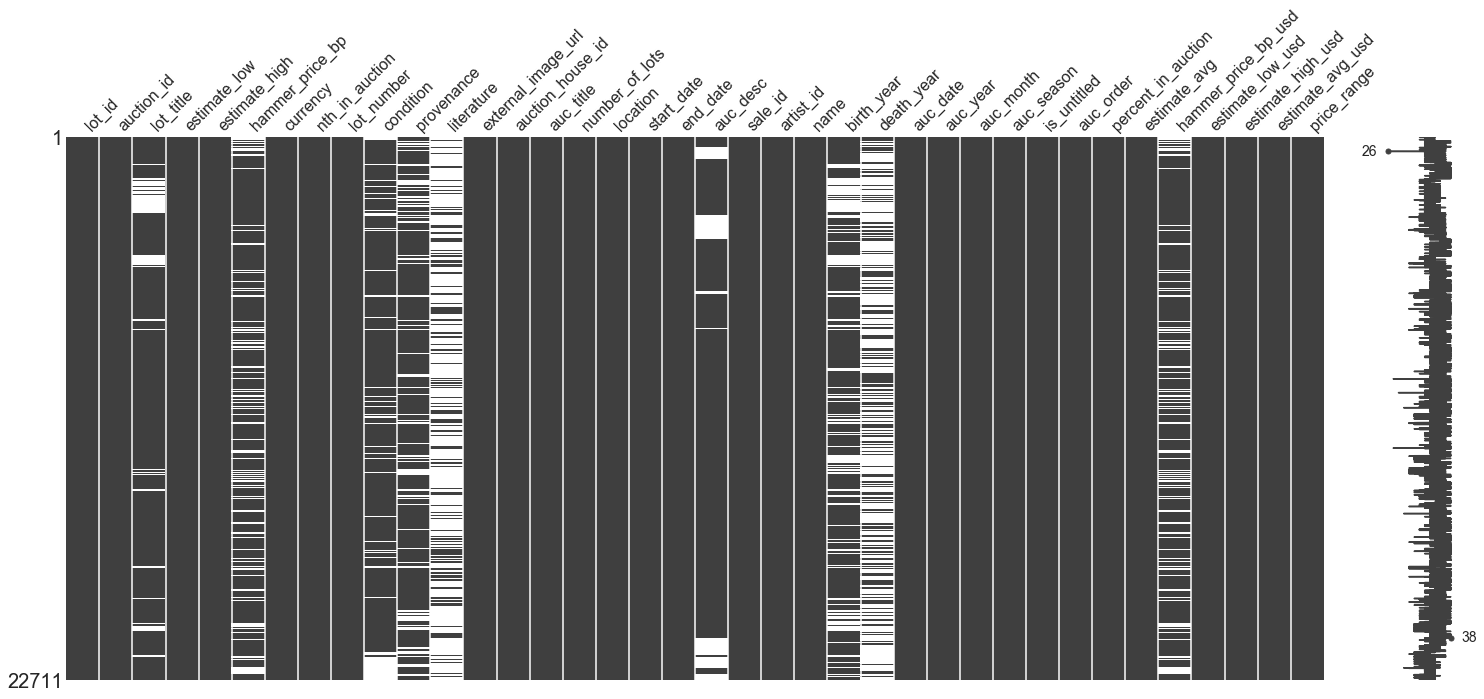

In [16]:
msno.matrix(df)

In [17]:
#check 
#change the 100% thing
#paracord- interactive
# temp=df.groupby("auc_id").size()

In [21]:
print(df[(df.auc_year > 2011) & (df.auc_year <= 2012)].shape)

(1462, 38)


,hammer_price_bp_usd,timeline_days,external_image_url
0,0.0,4380,http://www.sothebys.com/content/dam/stb/lots/N...
1,0.0,4380,http://www.sothebys.com/content/dam/stb/lots/N...
2,0.0,4380,http://www.sothebys.com/content/dam/stb/lots/N...
3,0.0,4380,http://www.sothebys.com/content/dam/stb/lots/N...
4,0.0,4380,http://www.sothebys.com/content/dam/stb/lots/N...


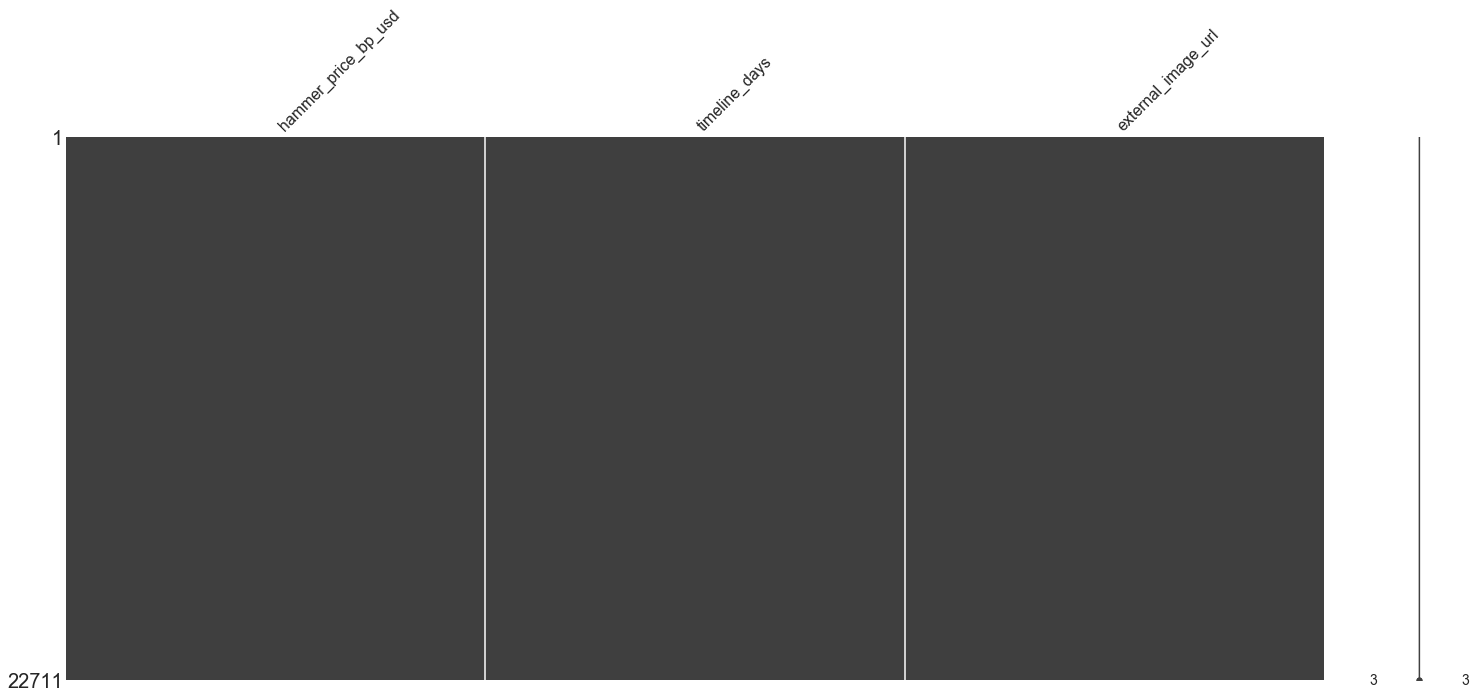

In [60]:
from datetime import date

start = min(df.auc_date).strftime('%Y-%m-%d')
y0, m0, d0 = [ int(x) for x in start.split("-") ]
date0 = date(y0, m0, d0)

def calc_days(x):
    y, m, d = [ int(x) for x in x.strftime('%Y-%m-%d').split("-") ]
    new_date = date(y, m, d)
    delta = new_date - date0
    return delta.days

df["timeline_days"] = df.auc_date.apply(calc_days)

interactive_df = df[['hammer_price_bp_usd', 'timeline_days', 'external_image_url']].copy()
interactive_df.fillna(0, inplace=True)

display(interactive_df.head())
msno.matrix(interactive_df)



In [ ]:
interactive_df.to_csv("interactive.csv")